# Model exploratory analysis

### In this notebook we are going to calibrate an enzymatic reaction PySB model, and then visualize the dynamics using the pyViPR widget.

### First, we import all the pythons libraries required

In [1]:
from pyvipr.pysb_models.mm_two_paths_model import model
import numpy as np
from pysb.simulator import ScipyOdeSimulator
import pyvipr as viz
from simplepso.pso import PSO
import matplotlib.pyplot as plt
%matplotlib inline

### Next, we load the data to which the model is going to be calibrated, and define the kinetic parameters that are going to be calibrated. Then, we define a cost function that determines how well the sampled parameter values reproduce the data. Finally, we run the Particle Swarm Optimization algorithm, and check that the calibrated parameters actually fit the experimental data

In [2]:
exp_avg = np.load('data/enzymatic_product_data.npy')
exp_sd = np.load('data/enzymatic_exp_sd.npy')

tspan = np.linspace(0, 10, 51)
solver = ScipyOdeSimulator(model, tspan=tspan)

idx_pars_calibrate = [0, 1, 2, 3, 4, 5]
rates_mask = [i in idx_pars_calibrate for i, par in enumerate(model.parameters)]

param_values = np.array([p.value for p in model.parameters])
starting_position = np.log10(param_values[rates_mask])

def likelihood(position):
    param_values[rates_mask] = 10 ** position
    sim = solver.run(param_values=param_values).all
    e1 = np.sum((exp_avg - sim['Product']) ** 2 / (2 * exp_sd)) / len(exp_avg)
    return e1,

pso = PSO(save_sampled=False, verbose=True, num_proc=4)
pso.set_cost_function(likelihood)
pso.set_start_position(starting_position)
pso.set_bounds(2)
pso.set_speed(-0.25, 0.25)
pso.run(25, 100)

iteration	best   	avg            	std            	min           	max            
1        	204.515	[2235.48619562]	[1725.93496665]	[204.51469336]	[4977.08309346]
2        	30.0903	[2026.34793903]	[1780.02213385]	[30.09027199] 	[4918.74287478]
3        	18.7156	[1806.78542188]	[1731.97946804]	[18.71556377] 	[4817.66827946]
4        	17.7466	[1560.37476612]	[1635.83473047]	[17.74662324] 	[4647.33934688]
5        	17.7466	[1163.81798369]	[1462.92230946]	[65.08470911] 	[4576.3206436] 
6        	17.7466	[701.42793633] 	[1002.44017981]	[50.06502752] 	[3740.61034219]
7        	11.3384	[413.06736491] 	[568.52174652] 	[11.33839201] 	[2257.74994168]
8        	3.91147	[196.40251933] 	[223.38903751] 	[3.91146966]  	[1150.05095117]
9        	3.91147	[141.11695813] 	[136.82821245] 	[13.84295167] 	[593.86862664] 
10       	3.91147	[62.06079242]  	[39.38352068]  	[8.39481427]  	[179.31667021] 
11       	2.29953	[84.57581895]  	[91.14022029]  	[2.2995307]   	[352.86851644] 
12       	1.41119	[133.99783

### We can plot the simulated data and the experimental data to make sure that the calibrated parameters fit the experimental data

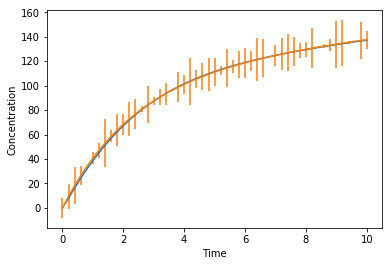

In [3]:
param_values[rates_mask] = 10 ** pso.best
sim = solver.run(param_values=param_values)
plt.plot(tspan, sim.all['Product'], label='Produc sim')
plt.errorbar(tspan, exp_avg, yerr=exp_sd)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

### After calibrating the model, we can visualize the dynamics of the multiple interactions occurring , and generate mechanistic insights about the regulation of the model

In [4]:
viz.sp_dyn_view(simulation=sim)

pysbViz(data=<pysb.simulator.base.SimulationResult object at 0x1115f5ba8>, layout_name='preset', type_of_viz='…